## Import lib.

In [257]:
import os
import zipfile

import torch
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F


from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np 


## Import data

In [64]:
with open(".env") as f:
    for line in f:
        key, val = line.strip().split("=")
        os.environ[key] = val

# print("Kaggle user:", os.environ['KAGGLE_USERNAME'])  
# print("Kaggle user:", os.environ['KAGGLE_KEY'])  

In [ ]:
# !kaggle datasets download -d fantacher/neu-metal-surface-defects-data

Dataset URL: https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data
License(s): other




  0%|          | 0.00/57.4M [00:00<?, ?B/s]
100%|██████████| 57.4M/57.4M [00:00<00:00, 1.55GB/s]


In [ ]:
# with zipfile.ZipFile("neu-metal-surface-defects-data.zip", "r") as zip_ref:
#     zip_ref.extractall("neu_defects")

In [206]:
base_path = r"D:\Metal_surface_defect\neu_defects\NEU Metal Surface Defects Data"
splits = ["train", "test", "valid"]
classes = ["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]


In [210]:
def get_all_images(base_path, split, classes):
    images = []
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        images += [os.path.join(folder, img) for img in os.listdir(folder)]
    return images

train_images = get_all_images(base_path, "train", classes)
test_images = get_all_images(base_path, "test", classes)
val_images = get_all_images(base_path, "valid", classes)

print(f"Train images count: {len(train_images)}")
print(f"Test images count: {len(test_images)}")
print(f"Validation images count: {len(val_images)}")

Train images count: 1656
Test images count: 72
Validation images count: 72


## Image Processing 

In [208]:
img = cv2.imread(train_images[276]) #0 - 275 change type

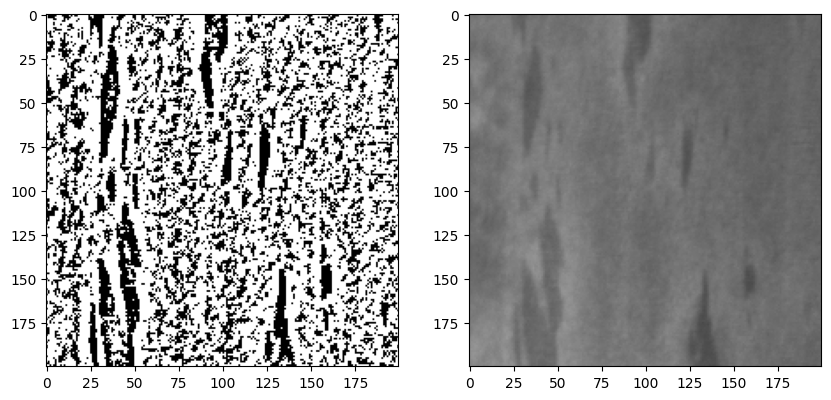

In [209]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
adaptive = cv2.adaptiveThreshold(
    gray,                    # input image (must be 8-bit grayscale)
    255,                        # max value to use with THRESH_BINARY
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # adaptive method (or cv2.ADAPTIVE_THRESH_MEAN_C)
    cv2.THRESH_BINARY,          # threshold type
    15,                         # block size (must be odd)
    2                           # C: constant subtracted from mean/weighted mean
)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(adaptive,cmap='gray')
plt.subplot(122)
plt.imshow(img)

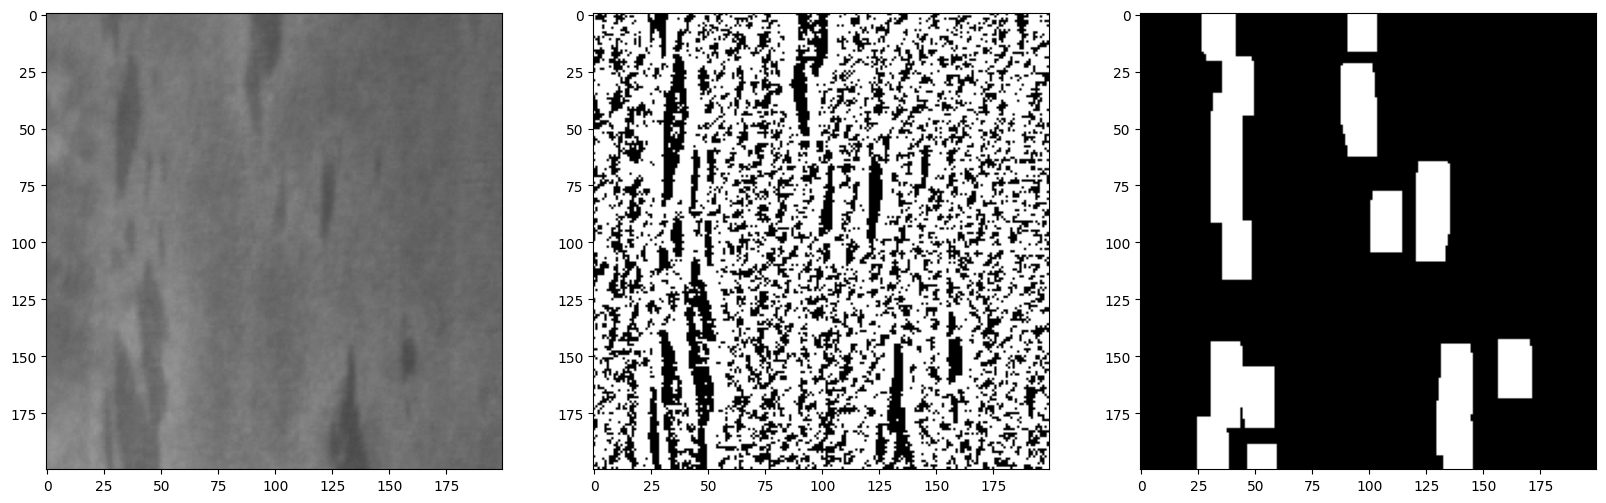

In [9]:
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 13))
vertical_lines = cv2.morphologyEx(adaptive, cv2.MORPH_CLOSE, vertical_kernel, iterations=1)
inverted = cv2.bitwise_not(vertical_lines)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
dilation = cv2.dilate(inverted,kernel,iterations=10)

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(adaptive,cmap='gray')
plt.subplot(133)
plt.imshow(dilation,cmap='gray')

## Create labels

In [211]:
classes = ["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
class_to_idx

{'Crazing': 0,
 'Inclusion': 1,
 'Patches': 2,
 'Pitted': 3,
 'Rolled': 4,
 'Scratches': 5}

In [219]:
train_images[0]

'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_120.bmp'

In [212]:
def get_label(image_path):
    for cls in classes:
        if f"\\{cls}\\" in image_path or f"/{cls}/" in image_path:
            return class_to_idx[cls]
    raise ValueError(f"Class not found in path: {image_path}")

In [213]:
train_labels = [get_label(path) for path in train_images]
test_labels = [get_label(path) for path in test_images]
val_labels = [get_label(path) for path in val_images]

In [220]:
print(train_labels[0])
print(train_labels[276])
print(train_labels[552])

0
1
2


## Prepare data

In [221]:
set(train_labels) #number of classes.

{0, 1, 2, 3, 4, 5}

In [222]:
train_images[:5]

['D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_120.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_121.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_122.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_123.bmp',
 'D:\\Metal_surface_defect\\neu_defects\\NEU Metal Surface Defects Data\\train\\Crazing\\Cr_124.bmp']

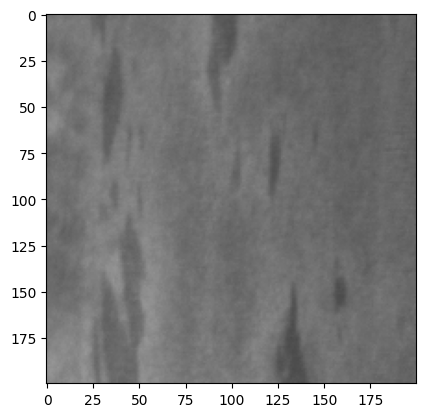

In [223]:
plt.imshow(cv2.imread(train_images[276])) #correct idx

## Data augmentation

In [249]:
base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

aug_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

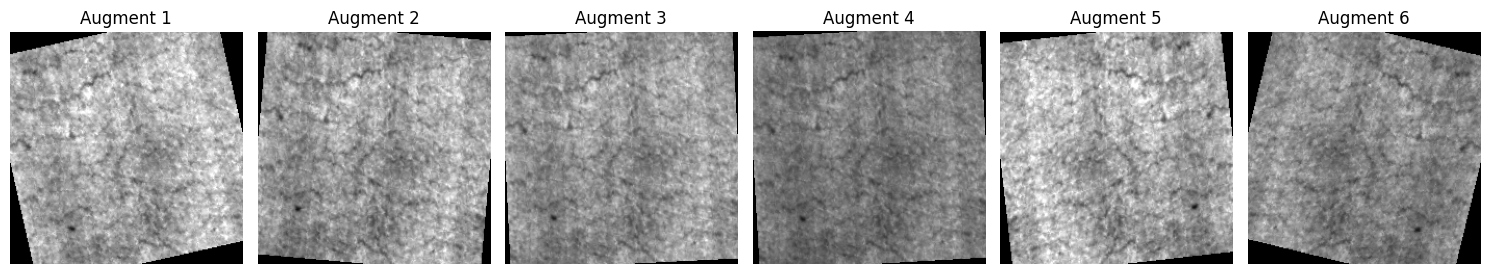

In [250]:
img = Image.open(train_images[0]).convert("RGB")

plt.figure(figsize=(15, 5))
for i in range(6):
    aug_img = aug_transform(img)
    plt.subplot(1, 6, i+1)
    plt.imshow(aug_img.permute(1, 2, 0))  # CHW -> HWC
    plt.axis("off")
    plt.title(f'Augment {i+1}')
plt.tight_layout()
plt.show()

## Dataloader

In [294]:
class MatalDataset(Dataset):
    def __init__(self,X,y,base_transform=None,aug_transform=None):
        self.x = [cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2RGB) for i in X]
        self.y = y
        self.base_transform = base_transform
        self.aug_transform = aug_transform
        print(f'size original image {self.x[0].shape}')
        print(f'size aumented image {aug_transform.transforms[0].size}')
        print('Number of original images',len(self.x))


    def __getitem__(self, index):
        x = Image.fromarray(self.x[index])
        y = self.y[index]
        original = self.base_transform(x) if self.base_transform else x
        augmented = self.aug_transform(x) if self.aug_transform else x 

        return original , augmented , y 
    
    def __len__(self):
        return len(self.x)



In [ ]:
datasets = MatalDataset(train_images,train_labels,base_transform,aug_transform)
ori , aug , la = datasets[0]

# original_img = F.to_pil_image(ori) 
# augmented_img = F.to_pil_image(aug)

# plt.figure(figsize=(8, 4))

# plt.subplot(1, 2, 1)
# plt.imshow(original_img)
# plt.title(f'Original (Label: {la})')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(augmented_img)
# plt.title(f'Augmented')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

size original image (200, 200, 3)
size aumented image (224, 224)
Number of original images 1656


In [252]:
class DoubleDataset(Dataset):
    def __init__(self, matal_dataset):
        self.dataset = matal_dataset
        print('final size',self.dataset[0][0].shape)
        print('Number of original+aug images',len(self.dataset)* 2)
        print("-"*50)

    def __len__(self):
        return len(self.dataset) * 2

    def __getitem__(self, idx):
        base_idx = idx % len(self.dataset) #Mathemetical miracle ???
        orig, aug, y = self.dataset[base_idx]

        if idx < len(self.dataset):
            return orig, y  # original
        else:
            return aug, y   # augmented



In [ ]:
train_loader = DataLoader(DoubleDataset(MatalDataset(train_images, train_labels, base_transform, aug_transform)),
                           batch_size=4,
                             shuffle=True)

val_loader = DataLoader(DoubleDataset(MatalDataset(val_images, val_labels, base_transform, aug_transform)),
                           batch_size=4,
                             shuffle=False)

test_loader = DataLoader(DoubleDataset(MatalDataset(test_images, test_labels, base_transform, aug_transform)),
                           batch_size=4,
                             shuffle=False)


size original image (200, 200, 3)
size aumented image (224, 224)
Number of original images 1656
final size torch.Size([3, 224, 224])
Number of original+aug images 3312
--------------------------------------------------
size original image (200, 200, 3)
size aumented image (224, 224)
Number of original images 72
final size torch.Size([3, 224, 224])
Number of original+aug images 144
--------------------------------------------------
size original image (200, 200, 3)
size aumented image (224, 224)
Number of original images 72
final size torch.Size([3, 224, 224])
Number of original+aug images 144
--------------------------------------------------


## Training

In [273]:
output_size = len(set(train_labels))
output_size

6

In [296]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=output_size):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # (B,16,224,224)
        self.pool = nn.MaxPool2d(2, 2)                           # (B,16,112,112)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # (B,32,112,112)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (B,64,112,112)

        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (B,16,112,112)
        x = self.pool(F.relu(self.conv2(x)))  # -> (B,32,56,56)
        x = self.pool(F.relu(self.conv3(x)))  # -> (B,64,28,28)
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [297]:
model = SimpleCNN(output_size)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [298]:
model = SimpleCNN(output_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(),lr=learning_rate)

In [299]:
from tqdm import tqdm

In [ ]:
# check_datasets , model 

In [300]:
n_epoch = 2
train_loss_plot = []

for epoch in range(n_epoch):
    
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{n_epoch}]")
    for inputs , labels in loop:
        #setting
        inputs,labels = inputs.to(device) , labels.to(device)
        optim.zero_grad()

        #forward
        outputs = model(inputs)
        loss = criterion(outputs,labels)

        #backward 
        loss.backward()

        #update
        optim.step()

        #keep
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_correct += predicted.eq(labels).sum().item()
        train_total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100. * train_correct / train_total)

    epoch_loss = train_loss / len(train_loader)
    train_loss_plot.append(epoch_loss)
    epoch_acc = 100. * train_correct / train_total 
    print(f"Epoch {epoch+1} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

Epoch [1/2]: 100%|██████████| 207/207 [00:23<00:00,  8.98it/s, acc=16.7, loss=1.84] 


Epoch 1 | Loss: 1513.5768 | Accuracy: 16.67%


Epoch [2/2]: 100%|██████████| 207/207 [00:23<00:00,  8.96it/s, acc=16.1, loss=1.82]

Epoch 2 | Loss: 1.8045 | Accuracy: 16.06%
